# **Latent Dirichlet Allocation (LDA)**


In [0]:
from google.colab import files, auth, drive

In [407]:
# Mount to drive
drive.mount('/content/gdrive', force_remount=True)
data_dir_drive ='/content/gdrive/My Drive/Colab Notebooks/PP/Project/'

Mounted at /content/gdrive


In [408]:
!pip install pymc

In [0]:
# import resources
import numpy as np
import pymc as pm
from matplotlib import pyplot as plt
from scipy.spatial import distance
import seaborn as sn
import pandas as pd

## **Document preprocessing class**
The class that, for a series of documents, builds the vocabulary annex to the list of documents. For each word of each document is attached a unique index, this is the vocabulary - a dictionary word unique index. And the returned feature vector is a list of lists that contains for each word in the original text its index in the vocabulary.

In [0]:
class PreprocessingInput:
    def __init__(self):
        self.vocabulary = {}

    def __init__(self, documents):
        self.vocabulary = {}
        self.build_dictionary(documents)

    def build_dictionary(self, documents = []):
        for doc in documents:
            doc = doc.replace(",.?!1234567890'", "").lower()
            words = doc.split(' ')
            for word in words:
                if word in self.vocabulary:
                    pass
                else:
                    self.vocabulary[word] = len(self.vocabulary)

    def get_vocabulary(self):
        return self.vocabulary

    def build_features(self, documents = []):
        self.build_dictionary(documents)
        featuresDoc = []
        for doc in documents:
            doc = doc.replace(",.?!1234567890'", "").lower()
            words = doc.split(' ')
            l = []
            for word in words:
                l.append(self.vocabulary[word])
            featuresDoc.append(l)
        return featuresDoc

    def get_features(self, documents = []):
        return self.build_features(documents)


In [411]:
#Testing the PreprocessingInput class
docs = ['I had a peanuts butter sandwich for breackfast',
        'I like to eat almonds, peanuts and walnuts',
        'My neighbor got a little dog yesterday',
        'Cats and dogs are mortal enemies',
        'You mustn’t feed peanuts to your dog']

preprocessingInputObj = PreprocessingInput(docs)

vocabulary = preprocessingInputObj.get_vocabulary()
features = preprocessingInputObj.get_features(docs)
print(vocabulary)
print(features)

{'i': 0, 'had': 1, 'a': 2, 'peanuts': 3, 'butter': 4, 'sandwich': 5, 'for': 6, 'breackfast': 7, 'like': 8, 'to': 9, 'eat': 10, 'almonds,': 11, 'and': 12, 'walnuts': 13, 'my': 14, 'neighbor': 15, 'got': 16, 'little': 17, 'dog': 18, 'yesterday': 19, 'cats': 20, 'dogs': 21, 'are': 22, 'mortal': 23, 'enemies': 24, 'you': 25, 'mustn’t': 26, 'feed': 27, 'your': 28}
[[0, 1, 2, 3, 4, 5, 6, 7], [0, 8, 9, 10, 11, 3, 12, 13], [14, 15, 16, 2, 17, 18, 19], [20, 12, 21, 22, 23, 24], [25, 26, 27, 3, 9, 28, 18]]


## **LDA Class**
This class implements the LDA algorithm for a number of documents and a number of topics. Contains fields for all observed and unobserved variables and for the preprocessing class.

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/9f341f1b85d2fa5e1b8574fec90d484f15eb85aa)

In [0]:
class LDAclass:
    def __init__(self, documents, K):
        # documents
        self.documents = documents
        # number of topics
        self.K = K
        self.preprocessingInputObj = PreprocessingInput(documents)
        self.vocabulary = preprocessingInputObj.get_vocabulary()
        self.features = preprocessingInputObj.get_features(documents)
        # number of words in the vocabulary
        self.V = len(vocabulary)
        # number of documents
        self.M = len(documents)
        # number of words in document d
        self.N = [len(x) for x in self.features]
        # prior weight of topic k in a document; 
        # usually the same for all topics; normally a number less than 1, 
        # e.g. 0.1, to prefer sparse topic distributions
        self.alfa = np.zeros(self.K)
        # prior weight of word w in a topic; usually the same for all words; 
        # normally a number much less than 1, e.g. 0.001, 
        # to strongly prefer sparse word distributions, i.e. few words per topic
        self.beta = np.zeros(self.V)
        # distribution of words in topic k
        self.phi = pm.Container([])
        # distribution of topics in document d
        self.theta = pm.Container([])
        # identity of topic of all words in all documents
        self.Z = pm.Container([])
        # identity of all words in all documents
        self.W = pm.Container([])

    # getter
    def getVocabulary(self):
        return self.vocabulary

    # build the hyperparameters
    def initializeHyperparameters(self, alfa = 1, beta = 1):
        if alfa > 1 or alfa < 0 or beta > 1 or beta < 0:
            raise ValueError('alfa and beta must be in [0, 1]')
        self.alfa += alfa
        self.beta += beta

    # set apriori distribution of words in topic k
    def setDistributionOfWordsInTopics(self):
        phi = []
        for topic in range(self.K):
            phi.append(pm.CompletedDirichlet("phi" + str(topic), pm.Dirichlet("insidePhi" + str(topic), self.beta)))
        self.phi = pm.Container(phi)

    # set apriori distribution of topics in document d
    def setProbabilitysOfTopicsOccurringInDocuments(self):
        theta = []
        for doc in range(self.M):
            theta.append(pm.CompletedDirichlet("theta" + str(doc), pm.Dirichlet("insideTheta" + str(doc), self.alfa)))
        self.theta = pm.Container(theta)

    # set apriori identity of topic of all words in all documents
    def identityOfTopicsOfAllWordsInAllDocuments(self):
        Z = []
        for doc in range(self.M):
            Z.append(pm.Categorical("Z" + str(doc), p=self.theta[doc], 
                                                  size=self.N[doc], 
                                                  value=np.random.randint(self.K, size=self.N[doc]),
                                                  observed=False))
        self.Z = pm.Container(Z)
        
    # construct only observated variable W
    def identityOfAllWordsInAllDocuments(self, observed=False):
        W = []
        for doc in range(self.M):
            WLine = []
            for i in range(self.N[doc]):
                WLine.append(pm.Categorical("W" + str(doc) + str(i),
                                 p=pm.Lambda("phi_z" + str(doc) + str(i), lambda z=self.Z[doc][i], phi=self.phi: phi[z]),
                                 value=self.features[doc][i],
                                 observed=observed))
            W.append(WLine)
        self.W = pm.Container(W)

    # build all of these variables to reach to W (observated variable based on all variables phi, theta, Z, alfa, beta)
    def buildObservedBariables(self):
        self.setDistributionOfWordsInTopics()
        self.setProbabilitysOfTopicsOccurringInDocuments()
        self.identityOfTopicsOfAllWordsInAllDocuments()
        self.identityOfAllWordsInAllDocuments(True)

    # buid the model
    def makeModel(self, iter = 10000, burn = 5000):
        self.model = pm.Model([self.theta, self.phi, self.Z, self.W])
        self.mcmc = pm.MCMC(self.model)
        self.mcmc.sample(iter, burn)

    # trace method 
    def trace(self):
        phi_trace = []
        for topic in range(self.K):
            phi_trace.append(self.mcmc.trace('phi' + str(topic))[:][:, 0])

        theta_trace = []
        for doc in range(self.M):
            theta_trace.append(self.mcmc.trace('theta' + str(doc))[:][:, 0])

        Z_trace = []
        for doc in range(self.M):
            Z_trace.append(self.mcmc.trace('Z' + str(doc))[:])

        return phi_trace, theta_trace, Z_trace 

In [413]:
# Testing LDA Class
LDAobj = LDAclass(documents = docs, K = 2)
LDAobj.initializeHyperparameters(alfa = 1, beta = 1)
LDAobj.buildObservedBariables()
LDAobj.makeModel()

 [-----------------100%-----------------] 10000 of 10000 complete in 20.6 sec

In [414]:
phi_trace, theta_trace, Z_trace = LDAobj.trace()
print(np.array(phi_trace).shape)
print(np.array(theta_trace).shape)

(2, 5000, 29)
(5, 5000, 2)


In [415]:
print(np.array(theta_trace).mean(axis = 1))

[[0.17837386 0.82162614]
 [0.5760565  0.4239435 ]
 [0.26567656 0.73432344]
 [0.34482451 0.65517549]
 [0.41999801 0.58000199]]


In [416]:
print(np.array(phi_trace).mean(axis = 1))

[[0.03693523 0.00663112 0.02496044 0.0830401  0.01373013 0.00028571
  0.0006577  0.04922967 0.0411473  0.03830358 0.02814382 0.08439348
  0.03688571 0.03905105 0.01977629 0.02561452 0.00883435 0.02442932
  0.04958608 0.10814117 0.02837444 0.06648156 0.04788125 0.01575807
  0.0073829  0.03289736 0.00921705 0.03945985 0.03277077]
 [0.02913861 0.03149664 0.06097471 0.015973   0.03038006 0.10526403
  0.03477299 0.06532459 0.02719863 0.01182718 0.01256299 0.01046545
  0.0471421  0.01235218 0.03834923 0.02475471 0.05857611 0.03671748
  0.04144234 0.03624403 0.01675288 0.0181538  0.03387235 0.0474774
  0.03777044 0.02709419 0.01256854 0.04035683 0.0349965 ]]


In [417]:
# Test2 LDA Class
docs = ["aaa bbb aaa",
        "bbb aaa bbb",
        "aaa bbb bbb aaa",
        "uuu vvv",
        "uuu vvv vvv",
        "uuu vvv vvv uuu"]

LDAobj = LDAclass(documents = docs, K = 2)
LDAobj.initializeHyperparameters(alfa = 1, beta = 1)
LDAobj.buildObservedBariables()
LDAobj.makeModel()

 [-----------------100%-----------------] 10000 of 10000 complete in 15.2 sec

In [418]:
phi_trace, theta_trace, Z_trace = LDAobj.trace()
print(np.array(phi_trace).shape)
print(np.array(theta_trace).shape)

(2, 5000, 33)
(6, 5000, 2)


In [419]:
print(np.array(theta_trace).mean(axis = 1))

[[0.24889276 0.75110724]
 [0.21608298 0.78391702]
 [0.21232894 0.78767106]
 [0.25726956 0.74273044]
 [0.2043072  0.7956928 ]
 [0.18727399 0.81272601]]


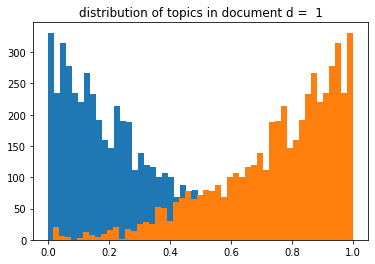

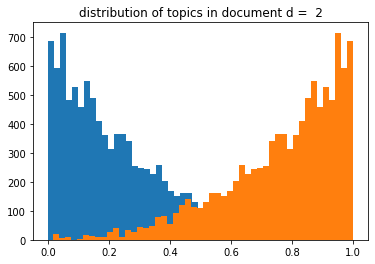

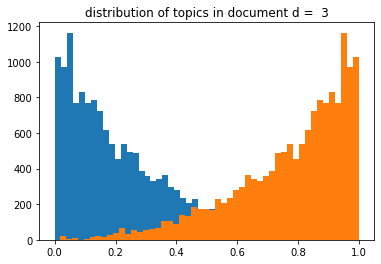

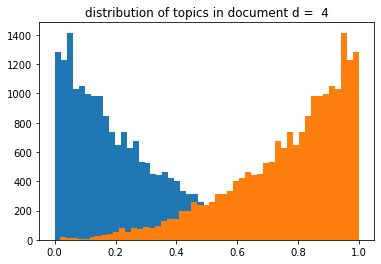

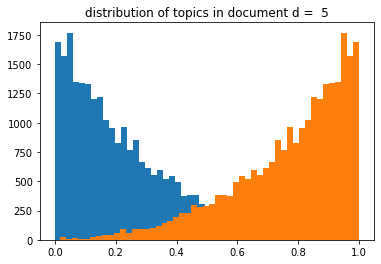

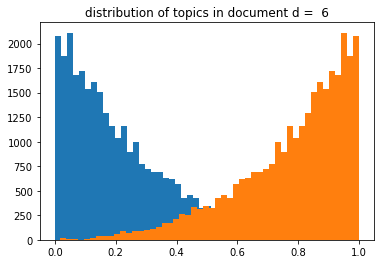

In [420]:
# Graphs on the distribution of topics in documents, information taken from theta after all samples
l1 = []
l2 = []
for doc in range(len(theta_trace)):
    for i in theta_trace[doc]:
        l1.append(i[0])
        l2.append(i[1])
    
    plt.hist(l1, bins = 50, label='topic 1')
    plt.hist(l2, bins = 50, label='topic 2')

    plt.title('distribution of topics in document d =  ' + str(doc + 1))
    plt.show()

In [421]:
print(np.array(phi_trace).mean(axis = 1))

[[0.07140957 0.01403298 0.02353659 0.0173081  0.00187938 0.01727028
  0.03248348 0.01623919 0.0306409  0.03805064 0.01531644 0.05346568
  0.0025512  0.08764707 0.04207437 0.02371803 0.03955134 0.03936097
  0.04737618 0.035677   0.01025825 0.01452549 0.00698038 0.01830508
  0.01303227 0.05669527 0.02637011 0.03232121 0.06299473 0.05097364
  0.00928753 0.00149387 0.04717276]
 [0.00801317 0.03728402 0.002653   0.01760938 0.01819954 0.04307951
  0.02822057 0.00334223 0.00851951 0.0029525  0.00129464 0.02877055
  0.04171    0.02746012 0.01825299 0.00151474 0.01640091 0.01878233
  0.03097081 0.03175896 0.03316838 0.02191432 0.01324524 0.01735694
  0.0024245  0.01356687 0.02016788 0.03123165 0.01477434 0.12299988
  0.04394134 0.13456086 0.1438583 ]]


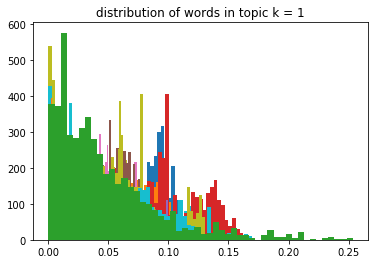

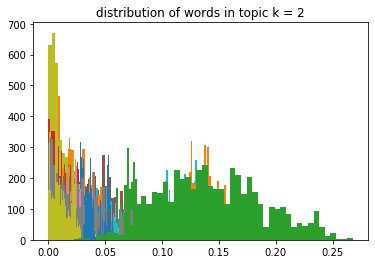

In [422]:
# Graphs on the distribution of words in topics, information taken from phi after all samples
for topic in range(len(phi_trace)):
    aux = np.array(phi_trace[topic])

    dist = []
    for word in range(aux.shape[1]):
        d = []
        for i in range(aux.shape[0]):
            d.append(phi_trace[topic][i][word])
        dist.append(d)

    for word in range(aux.shape[1]):
        plt.hist(dist[word], bins = 50, label='topic 2')

    plt.title('distribution of words in topic k = ' + str(topic + 1))
    plt.show()

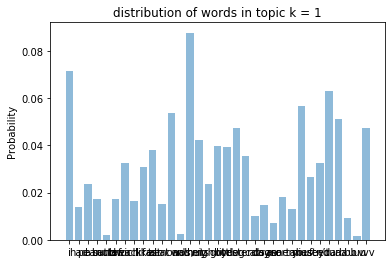

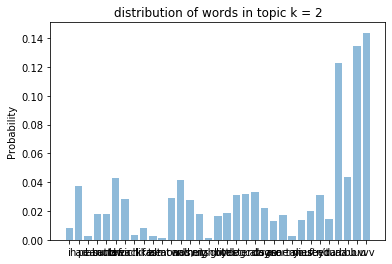

In [423]:
# Graphs 2 (more sugestive) on the distribution of words in topics, information taken from phi after all samples
vocab = LDAobj.getVocabulary()
y_pos = np.arange(len(vocab))

for topic in range(len(phi_trace)):
    aux = np.array(phi_trace[topic])

    performance = aux.mean(axis=0)

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, vocab.keys())
    plt.ylabel('Probability')
    plt.title('distribution of words in topic k = ' + str(topic + 1))

    plt.show()

In [424]:
print(Z_trace)

[array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]), array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]), array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       ...,
       [1, 0, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1]]), array([[1, 1],
       [1, 1],
       [1, 1],
       ...,
       [1, 1],
       [1, 1],
       [1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]), array([[1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       ...,
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1]])]


In [425]:
# Inferring Z 
Z_trace_final = []
for line in Z_trace:
    Z_trace_final.append(line[-1])

print(Z_trace_final)

[array([1, 1, 1]), array([1, 1, 1]), array([1, 1, 1, 1]), array([1, 1]), array([1, 1, 1]), array([1, 1, 1, 1])]


## **Now on our set of documents**


In [426]:
# Read data
f=open(data_dir_drive + "corpus.txt", "r")
fl =f.readlines()
corpus = []
for line in fl:
    corpus.append(line)

print(corpus)

['French toast is a dish made of sliced bread soaked in eggs and milk, then fried\n', 'In France, pain perdu has a wide range of regional variations\n', 'Okonomiyaki is a Japanese savory pancake containing a variety of ingredients\n', 'Sweet crepes are generally made with wheat flour (farine de froment). When sweet, they can be eaten as part of breakfast or as a dessert.\n', 'The supermassive black hole at the core of supergiant elliptical galaxy Messier 87\n', 'The Sun currently fuses about 600 million tons of hydrogen into helium every second, converting 4 million tons of matter into energy\n', "Presently, it is hypothesized that a magnetic dynamo within this layer generates the Sun's magnetic field.\n", 'Earth is the third planet from the Sun and the only astronomical object known to harbor life. According to radiometric dating and other sources of evidence, Earth formed over 4.5 billion years ago. \n', 'The Mind Sports Olympiad (MSO) is an annual international multi-disciplined com

In [427]:
# Testing preprocessind class
preprocessingInputObj = PreprocessingInput(corpus)

vocabulary = preprocessingInputObj.get_vocabulary()
features = preprocessingInputObj.get_features(corpus)
print(vocabulary)
print(features)

{'french': 0, 'toast': 1, 'is': 2, 'a': 3, 'dish': 4, 'made': 5, 'of': 6, 'sliced': 7, 'bread': 8, 'soaked': 9, 'in': 10, 'eggs': 11, 'and': 12, 'milk,': 13, 'then': 14, 'fried\n': 15, 'france,': 16, 'pain': 17, 'perdu': 18, 'has': 19, 'wide': 20, 'range': 21, 'regional': 22, 'variations\n': 23, 'okonomiyaki': 24, 'japanese': 25, 'savory': 26, 'pancake': 27, 'containing': 28, 'variety': 29, 'ingredients\n': 30, 'sweet': 31, 'crepes': 32, 'are': 33, 'generally': 34, 'with': 35, 'wheat': 36, 'flour': 37, '(farine': 38, 'de': 39, 'froment).': 40, 'when': 41, 'sweet,': 42, 'they': 43, 'can': 44, 'be': 45, 'eaten': 46, 'as': 47, 'part': 48, 'breakfast': 49, 'or': 50, 'dessert.\n': 51, 'the': 52, 'supermassive': 53, 'black': 54, 'hole': 55, 'at': 56, 'core': 57, 'supergiant': 58, 'elliptical': 59, 'galaxy': 60, 'messier': 61, '87\n': 62, 'sun': 63, 'currently': 64, 'fuses': 65, 'about': 66, '600': 67, 'million': 68, 'tons': 69, 'hydrogen': 70, 'into': 71, 'helium': 72, 'every': 73, 'second,'

In [428]:
# Clogs the ground for LDA
LDAobj = LDAclass(documents = corpus, K = 5)
LDAobj.initializeHyperparameters(alfa = 1, beta = 1)
LDAobj.buildObservedBariables()
LDAobj.makeModel()

 [-----------------100%-----------------] 10000 of 10000 complete in 304.0 sec

In [429]:
# Inferring phi, theta and Z
phi_trace, theta_trace, Z_trace = LDAobj.trace()
print(np.array(phi_trace).shape)
print(np.array(theta_trace).shape)

(5, 5000, 316)
(20, 5000, 5)


In [430]:
# Mean of these values on theta all over the samples
print(np.array(theta_trace).mean(axis = 1))

[[0.12334401 0.24512545 0.21632035 0.18652435 0.22868583]
 [0.09443351 0.18583251 0.40056433 0.18736311 0.13180655]
 [0.14680064 0.31342361 0.21624287 0.17801949 0.14551339]
 [0.05459283 0.14996065 0.42862228 0.29793573 0.0688885 ]
 [0.0998745  0.12400228 0.32233389 0.14710669 0.30668264]
 [0.09658408 0.23433841 0.39304082 0.05240681 0.22362988]
 [0.07398647 0.08208488 0.52486557 0.18119749 0.13786559]
 [0.03879339 0.18209291 0.39695374 0.1000991  0.28206087]
 [0.05601807 0.32305581 0.18678433 0.13523183 0.29890995]
 [0.13098567 0.08995084 0.40639154 0.12702924 0.24564272]
 [0.07182745 0.19951114 0.18535047 0.34625422 0.19705672]
 [0.10807179 0.3448093  0.30416132 0.11812588 0.12483171]
 [0.0589223  0.09907187 0.21699319 0.28723357 0.33777906]
 [0.05690753 0.22475305 0.23271879 0.22093183 0.2646888 ]
 [0.09678113 0.21279725 0.4140725  0.12272558 0.15362355]
 [0.10092654 0.43483765 0.08864388 0.25295034 0.12264159]
 [0.04503039 0.25787225 0.1663552  0.37035648 0.16038568]
 [0.07974297 0

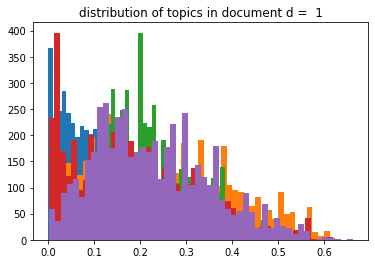

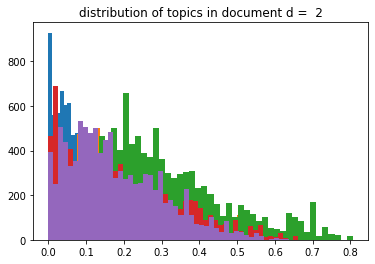

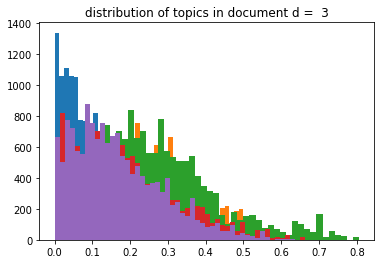

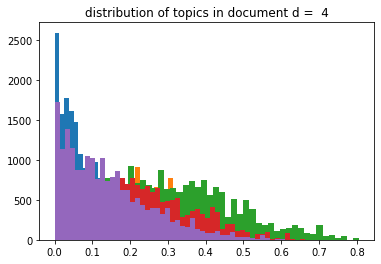

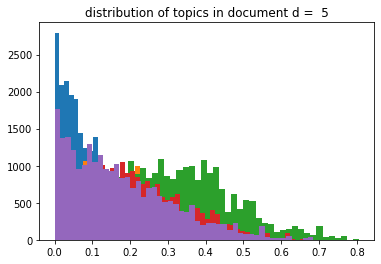

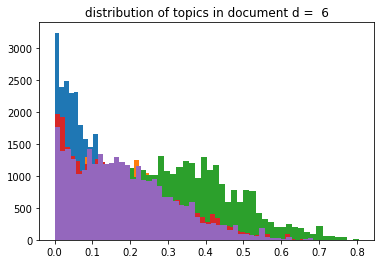

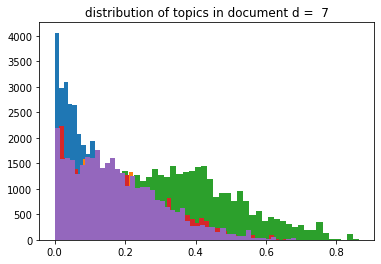

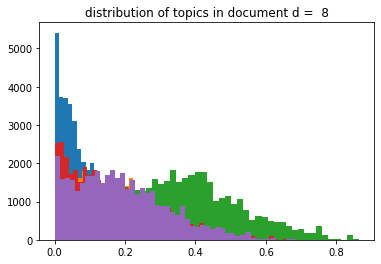

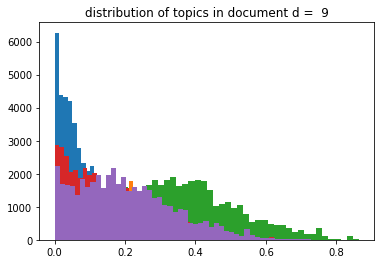

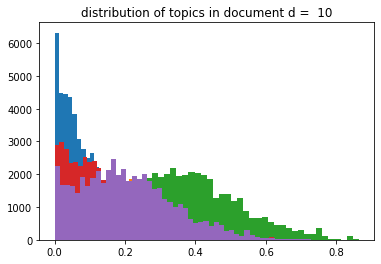

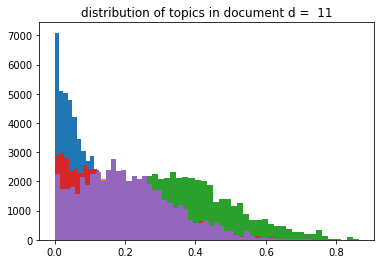

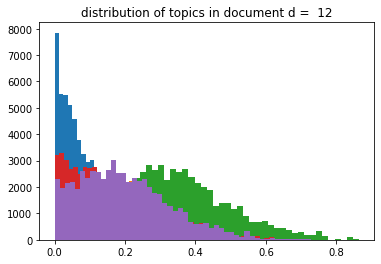

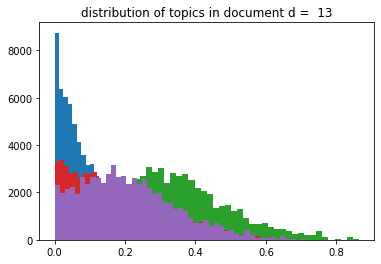

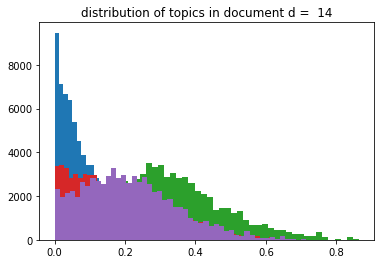

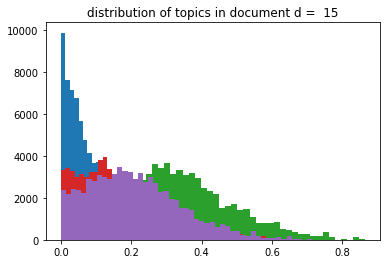

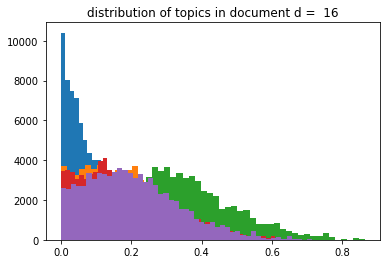

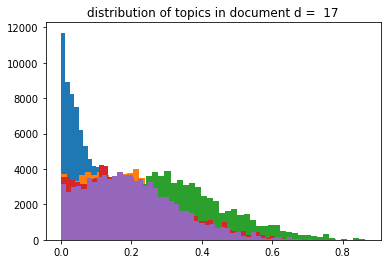

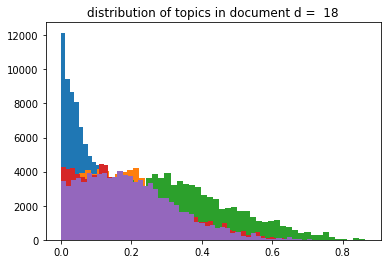

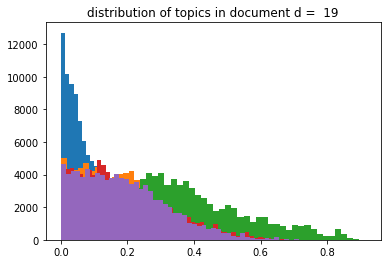

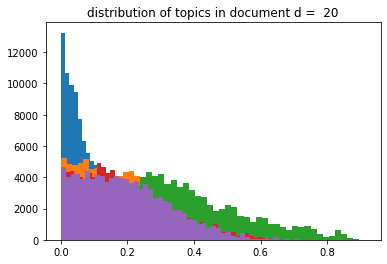

In [441]:
# Graphs on the distribution of topics in documents, information taken from theta after all samples

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
for doc in range(len(theta_trace)):
    for i in theta_trace[doc]:
        l1.append(i[0])
        l2.append(i[1])
        l3.append(i[2])
        l4.append(i[3])
        l5.append(i[4])
    
    plt.hist(l1, bins = 50, label='topic 1')
    plt.hist(l2, bins = 50, label='topic 2')
    plt.hist(l3, bins = 50, label='topic 3')
    plt.hist(l4, bins = 50, label='topic 4')
    plt.hist(l5, bins = 50, label='topic 5')

    plt.title('distribution of topics in document d =  ' + str(doc + 1))
    plt.show()

In [432]:
# Mean of these values on phi all over the samples

print(np.array(phi_trace).mean(axis = 1))

[[4.42415932e-03 6.38985611e-04 6.97735267e-03 ... 6.14805016e-04
  8.42886275e-05 5.76479840e-03]
 [6.38410091e-04 3.20606384e-03 2.75063577e-04 ... 2.10002453e-04
  2.23975323e-04 5.23969411e-03]
 [1.53608692e-02 4.25960639e-04 1.57690265e-02 ... 1.70260654e-04
  1.82659244e-04 3.39873227e-03]
 [1.13517375e-03 8.26896844e-04 3.69257008e-03 ... 1.33386987e-03
  8.05276149e-04 1.07766342e-02]
 [4.14549853e-03 2.33462333e-03 7.11336635e-03 ... 1.71080026e-03
  3.45402756e-03 7.17938408e-03]]


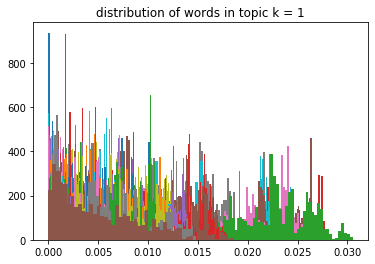

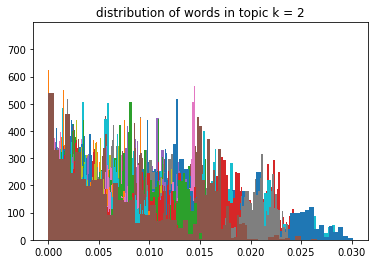

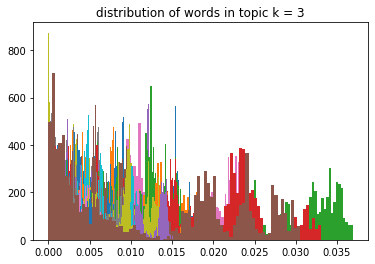

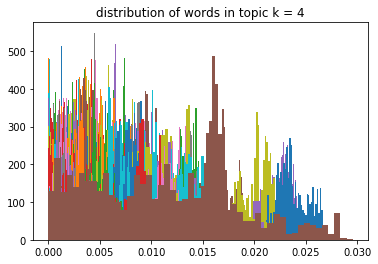

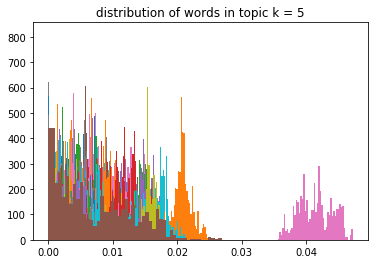

In [433]:
# Graphs  on the distribution of words in topics, information taken from phi after all samples

for topic in range(len(phi_trace)):
    aux = np.array(phi_trace[topic])

    dist = []
    for word in range(aux.shape[1]):
        d = []
        for i in range(aux.shape[0]):
            d.append(phi_trace[topic][i][word])
        dist.append(d)

    for word in range(aux.shape[1]):
        plt.hist(dist[word], bins = 50, label='topic 2')

    plt.title('distribution of words in topic k = ' + str(topic + 1))
    plt.show()

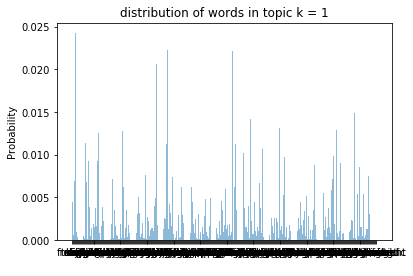

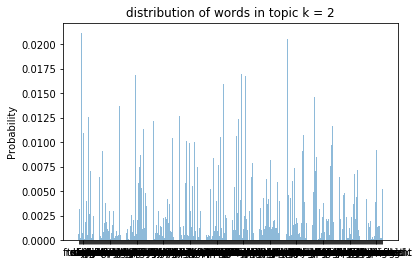

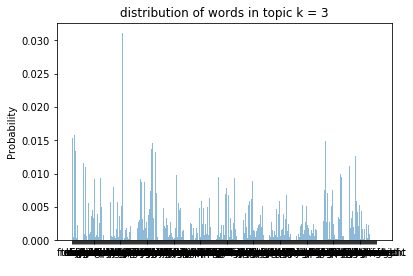

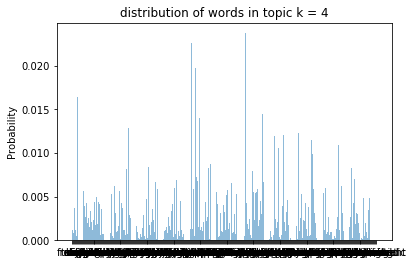

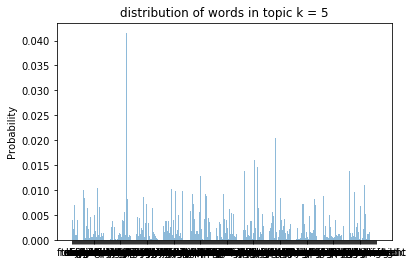

In [434]:
# Graphs 2 (more sugestive) on the distribution of words in topics, information taken from phi after all samples

vocab = LDAobj.getVocabulary()
y_pos = np.arange(len(vocab))

for topic in range(len(phi_trace)):
    aux = np.array(phi_trace[topic])

    performance = aux.mean(axis=0)

    plt.bar(y_pos, performance, align='center', alpha=0.5)
    plt.xticks(y_pos, vocab.keys())
    plt.ylabel('Probability')
    plt.title('distribution of words in topic k = ' + str(topic + 1))

    plt.show()

In [435]:
print(Z_trace)

[array([[2, 3, 4, ..., 3, 3, 4],
       [2, 3, 4, ..., 3, 3, 4],
       [2, 3, 4, ..., 3, 3, 4],
       ...,
       [1, 1, 3, ..., 4, 0, 3],
       [1, 1, 3, ..., 4, 0, 3],
       [1, 1, 3, ..., 4, 0, 3]]), array([[4, 4, 4, ..., 4, 3, 0],
       [4, 4, 4, ..., 4, 3, 0],
       [4, 4, 4, ..., 4, 3, 0],
       ...,
       [2, 1, 0, ..., 2, 1, 3],
       [2, 1, 1, ..., 2, 1, 3],
       [2, 1, 1, ..., 2, 1, 3]]), array([[3, 2, 0, ..., 2, 3, 3],
       [3, 2, 0, ..., 2, 3, 2],
       [3, 2, 0, ..., 2, 3, 2],
       ...,
       [2, 2, 0, ..., 2, 2, 4],
       [2, 2, 0, ..., 2, 2, 4],
       [2, 2, 0, ..., 3, 2, 3]]), array([[0, 0, 2, ..., 2, 1, 2],
       [0, 0, 2, ..., 2, 1, 2],
       [0, 0, 2, ..., 2, 1, 2],
       ...,
       [3, 2, 2, ..., 2, 1, 3],
       [3, 2, 2, ..., 2, 1, 3],
       [3, 2, 2, ..., 2, 1, 3]]), array([[4, 4, 4, ..., 4, 1, 1],
       [4, 4, 4, ..., 4, 1, 1],
       [4, 4, 4, ..., 4, 1, 1],
       ...,
       [2, 0, 4, ..., 2, 4, 2],
       [2, 0, 4, ..., 2, 4, 2],
   

In [436]:
# Inferring Z

Z_trace_final = []
for line in Z_trace:
    Z_trace_final.append(line[-1])

print(Z_trace_final)

[array([1, 1, 3, 1, 3, 1, 3, 3, 1, 0, 3, 0, 4, 4, 0, 3]), array([2, 1, 1, 1, 2, 2, 2, 3, 2, 1, 3]), array([2, 2, 0, 1, 2, 3, 4, 1, 3, 2, 3]), array([3, 2, 2, 3, 1, 2, 3, 2, 3, 2, 2, 3, 2, 1, 3, 1, 3, 2, 3, 2, 2, 2,
       2, 1, 3]), array([2, 0, 4, 3, 2, 2, 4, 2, 3, 3, 2, 4, 2]), array([2, 2, 1, 4, 4, 1, 2, 1, 2, 4, 2, 0, 2, 4, 1, 0, 4, 2, 2, 4, 2, 1]), array([3, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 4]), array([2, 2, 2, 1, 2, 3, 2, 1, 4, 2, 2, 4, 1, 2, 1, 4, 1, 4, 2, 4, 3, 2,
       1, 3, 2, 4, 2, 2, 1, 2, 2, 2, 2, 4]), array([2, 2, 1, 2, 2, 2, 1, 1, 2, 4, 1, 2, 3, 4, 4, 3, 1, 3, 1, 1, 1]), array([2, 4, 1, 4, 3, 3, 2, 4, 2, 2, 3, 2, 2, 2, 4, 1, 4, 1, 2, 4, 2, 2,
       3, 4, 2, 2, 0, 3, 1, 4, 2, 4, 4]), array([0, 3, 3, 1, 2, 2, 3, 2, 2, 2, 3, 2, 3, 1, 0, 2, 3, 2, 2, 1, 4, 2,
       3, 2, 2, 2, 3]), array([1, 4, 2, 1, 1, 4, 2, 4, 2, 2, 1, 3, 1, 4, 3, 3, 1, 1, 2, 2, 2, 2,
       4, 1, 3, 3, 2, 4, 3, 2, 2, 2, 2, 2, 2, 1, 2, 1]), array([4, 3, 2, 2, 2, 4, 2, 2, 1, 0, 4, 4, 4, 3, 3, 4, 

## **Similarity measure between documents**
Using jensenshannon and cosinus distance/divergence

In [0]:
theta_trace_mean = np.array(theta_trace).mean(axis = 1)

cosMatrix = []
jensenshannonMatrix = []

for i, doc1 in enumerate(theta_trace_mean):
    a = []
    b = []
    for j, doc2 in enumerate(theta_trace_mean):
        a.append(np.dot(doc1, doc2) / np.sqrt(np.dot(doc1, doc1) * np.dot(doc2, doc2)))
        b.append(distance.jensenshannon(doc1, doc2))
    cosMatrix.append(a)
    jensenshannonMatrix.append(b)

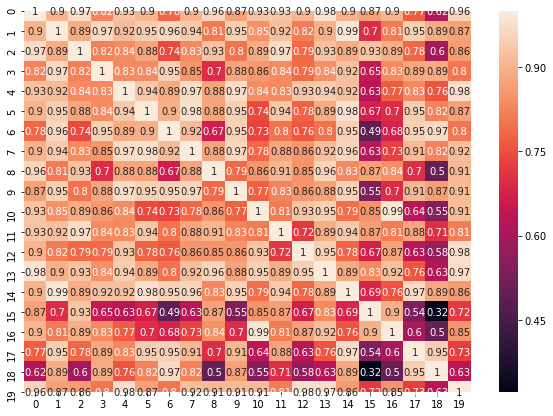

In [438]:
# plotting the <<confusion matrix of cosMatrix>>

df_cm = pd.DataFrame(cosMatrix, index = [i for i in range(len(cosMatrix))],
                  columns = [i for i in range(len(cosMatrix[i]))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

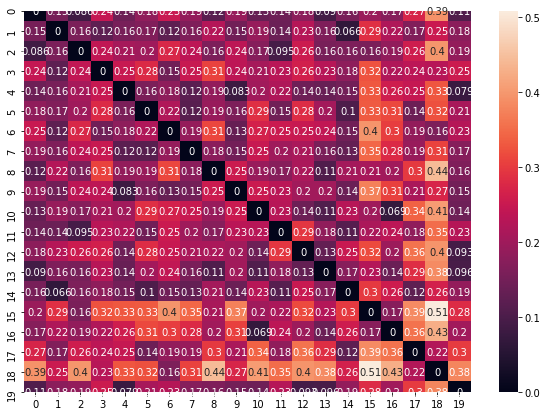

In [439]:
# plotting the <<confusion matrix of jensenshannonMatrix>>

df_cm = pd.DataFrame(jensenshannonMatrix, index = [i for i in range(len(jensenshannonMatrix))],
                  columns = [i for i in range(len(jensenshannonMatrix[i]))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## **Assign topics to a new document / unseen document**

In [440]:
new_document = "A team of international astronauts are sent on a dangerous mission to reignite the dying Sun with a nuclear fission bomb in 2057."

# add the new word to dictionary
preprocessingInputObj.build_dictionary([new_document])
# obtain the new one
vocabulary = preprocessingInputObj.get_vocabulary()
# make features for the new document
new_features = preprocessingInputObj.get_features([new_document])
print(vocabulary)
print(new_features)

# build the new theta for this document
new_theta = []
phi_trace_mean = np.array(phi_trace).mean(axis = 1)

for topic in range(5):
    topic_probability = 0
    for j in new_features[0]:
        # if exists j in phi_trace_mean
        try:
            topic_probability += phi_trace_mean[topic][j]
        except:
            None
    new_theta.append(topic_probability)

# work as well without softmax
print(softmax(new_theta))
print('topic = ' + str([i for i, j in enumerate(softmax(new_theta)) if j == np.max(softmax(new_theta))][0] + 1))

{'french': 0, 'toast': 1, 'is': 2, 'a': 3, 'dish': 4, 'made': 5, 'of': 6, 'sliced': 7, 'bread': 8, 'soaked': 9, 'in': 10, 'eggs': 11, 'and': 12, 'milk,': 13, 'then': 14, 'fried\n': 15, 'france,': 16, 'pain': 17, 'perdu': 18, 'has': 19, 'wide': 20, 'range': 21, 'regional': 22, 'variations\n': 23, 'okonomiyaki': 24, 'japanese': 25, 'savory': 26, 'pancake': 27, 'containing': 28, 'variety': 29, 'ingredients\n': 30, 'sweet': 31, 'crepes': 32, 'are': 33, 'generally': 34, 'with': 35, 'wheat': 36, 'flour': 37, '(farine': 38, 'de': 39, 'froment).': 40, 'when': 41, 'sweet,': 42, 'they': 43, 'can': 44, 'be': 45, 'eaten': 46, 'as': 47, 'part': 48, 'breakfast': 49, 'or': 50, 'dessert.\n': 51, 'the': 52, 'supermassive': 53, 'black': 54, 'hole': 55, 'at': 56, 'core': 57, 'supergiant': 58, 'elliptical': 59, 'galaxy': 60, 'messier': 61, '87\n': 62, 'sun': 63, 'currently': 64, 'fuses': 65, 'about': 66, '600': 67, 'million': 68, 'tons': 69, 'hydrogen': 70, 'into': 71, 'helium': 72, 'every': 73, 'second,'